In [10]:
import os
import shutil
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

import tensorflow.keras.layers as tkl
import tensorflow.keras as tk
import tensorflow as tf
tf.__version__

'2.0.0'

In [11]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

In [12]:
# Uncomment if you know what you're doing
shutil.rmtree('logs', ignore_errors=True)

from datetime import datetime
logdir = "./logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tk.callbacks.TensorBoard(log_dir=logdir)
os.makedirs(logdir, exist_ok=True)
print("Logging to %s" % logdir)

Logging to ./logs/scalars/20191019-164440


# The Supervised Learning Problem

Trading is a process that influences the environment. Transactions create fees, larger transactions will even influence prices. That's why we'll eventually be looking at this problem as a *Reinforcement Learning* (RL) problem. But for now, we'll concentrate on the questions whether a neural network can learn when to buy and when to sell, when it is trained by some heuristically derived labels. In RL, people would talk about expert training. The heuristic is the expert.

So: We set out to train an artificial neural network when to buy and when to sell. Let's define that challenge in easy mathematical terms, such that we can start implementing it. We are looking for a function that take as input some well-defined data from the market and our current portfolio and outputs a rebalancing recommendation.

### Prerequisites
In our experiment, we call 256 business days a year. GPUs are most efficient to chew on chunks with sizes of powers of two, that's why. Since we decided to study a synthetic case, that is not a limitation. Funny enough - it's quite close to reality, too.

### Input: Market Data
The market data input is described in [Understanding_the_Market.ipynb](Understanding_the_Market.ipynb). 

### Input: Expert Labels
We'll create some heuristic function that would always suggest to put the money in the single stock that has performed best during the last $n_d$ days, with $n_d$ being a duration between 2 and 128 days

### Output
The output of our neural network function is a new set of weights for the portfolio and the cash position. Once we're getting to *Reincorcement Learning*, we're going to call this function a *policy*, as it *suggests* the next action of rebalancing the portfolio. 

### Objective
What we're tryng to achieve is that the neural network will eventually copy the heuristic behaviour and only invest in the top-mover. Once that is working, we'll do the *real stuff*: Deep Reinforcement Learning. But for now, it's supervised learning.


## Using pre-produced data
Since the creation of market data takes such a long time, we'll be using pre-produced available in files. These files contain data of several different simulation runs. You can observe that the different runs produce very different data, although the *investors* are trading in exactly the same sentiment history. That's because the investors are created with random preferences for momentum and value and also their perception of the expected perceived value is modelled with some noise in it.

In [13]:
data = []
with open('charts.pkl', 'rb') as file:
    r=0
    while True:
        try: 
            data.append(pickle.load(file))
            r+=1
        except EOFError:
            print("Read %s samples." % r)
            break;


Read 2 samples.


Charts from two different simulation runs for the same sentiment history

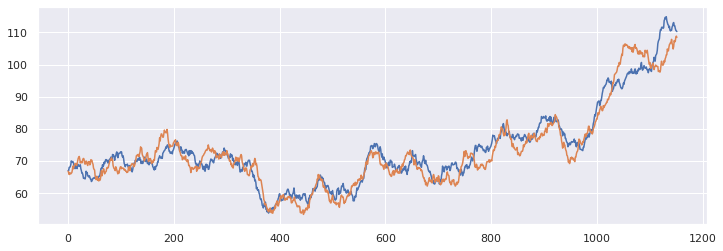

In [25]:
tickers = list(data[0].keys())
ticker = tickers[0]
plt.plot(data[0][ticker]['price']);
plt.plot(data[1][ticker]['price']);

## A market-like data source

In [26]:
class MarketFromData:
    """
    creates a market wrapper for an array or list of shape N_STOCKS x N_PRICES
    """
    def __init__(self, data, duration, nh, fee):
        """
        data: an array or list of shape [n_stocks, n_prices]
        nh: max. number of prices in history
        duration: the length of the period that can be served
        requires len(data) == duration + nh
        """
        self.duration = duration
        self.nh = nh
        self.data = np.array(data)
        self.n_securities = np.shape(self.data)[0]
        self.fee = fee
        length = np.shape(self.data)[1]
        if length != duration + nh:
            raise ValueError("record length not sum of duration and history.")
        # Need one more for the log returns
        np.append(self.data, self.data[:,-1:], axis = -1)
                    
    def log_return_history(self, nh, t):
        if t < 0 or t >= duration:
            raise ValueError("t must be between %s and %s" % (0, self.duration - 1))
        if nh > self.nh or nh <= 0:
            raise ValueError("t must be between %s and %s" % (1, self.nh))
        t += self.nh + 1
        
        h = self.data[ :, t-nh-1: t]
        return np.log(h[:, 1:] / h[:, :-1]).T
        
    def prices(self, t):
        return self.data[:, t]

In [27]:
from markets.stocks_model import MarketFromData

In [28]:
all_charts = np.array([data[0][ticker]['price'] for ticker in tickers])
market = MarketFromData(all_charts, 1024, 128, fee=2.5e-3)

This *market* is basically a data source, not a dynamic object the exposes behavior. We can ask it about the most recent price history of 8 closing prices of each traded stock as observed on the 200th trading day like this:

In [29]:
market.log_return_history(nh=8, t=200)

array([[ 0.01158543,  0.01018468, -0.00675895,  0.03029789,  0.        ,
        -0.00315781,  0.00540038, -0.00892717,  0.01403414,  0.03342717],
       [ 0.01713031,  0.00757101, -0.00680495,  0.        ,  0.01907272,
        -0.01273193, -0.01628944, -0.00599603,  0.0110872 , -0.00470744],
       [-0.01138754, -0.00504097, -0.01029504,  0.01112916, -0.00949089,
         0.01903762, -0.00824532,  0.00898062,  0.00823547,  0.00470744],
       [-0.02317164,  0.00504097,  0.        ,  0.        ,  0.01420277,
        -0.00314787, -0.00831387, -0.00597811,  0.0081682 ,  0.01399081],
       [-0.02372133, -0.01519979,  0.00687512,  0.00368236, -0.00471188,
         0.00628587,  0.        , -0.00601406,  0.00810202,  0.02289163],
       [ 0.        , -0.00768742,  0.01022486,  0.00366885,  0.0506484 ,
         0.01862396, -0.00558123, -0.00605045,  0.01600973, -0.0045366 ],
       [ 0.00896157,  0.        ,  0.01347253,  0.00729757,  0.        ,
         0.0091835 ,  0.01113148,  0.        

In [30]:
# One million in cash and 100'000 worth of every available stock
portfolio= [1e6] + 10 * [1e5]
print(portfolio)

[1000000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0]


## OpenAI's *environment*

In [31]:
from drl.trading_model import MarketEnvironment

In [32]:
env = MarketEnvironment(
    market=market, 
    n_hist=128, 
    t_init=0, 
    portfolio=portfolio,     
    return_scale = 100,
    weight_scale = 1.0,    
)

#### The environment provides input data
In the tradition of openai's environment, we get our input data by querying the state of the environment. First we see the price history already shaped such that it can readily be fed into a convolutional neural network: 1 channel (colour images would have a three here), input as 10 stocks with 128 points of history data, and 1 for the number of records in a batch, since we have a single observation.

In [33]:
env.state()[0].shape

(1, 128, 10, 1)

And the other part is the current portfolio including the cash position

In [34]:
weights = env.state()[1]
weights

array([[0.5 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],
      dtype=float32)

Later, we will interact with this environment by calling the ```step(...)``` method that takes the new portfolio weights as input. Note that this environment does not actually execute the trade on it's underlying market instance, since (remember?) that instance is a read-only market. The environment does re-balance the portfolio though and it also subtracts the fee that the market demands.

## The Convolutional Network Architecture

We feed a history of 7 prices from 2 different assets (stocks) into the network. The design is such that the convolution transitions from stock to stock, always probing the entire history of 7 prices. The convolutional layers output is being fed into a 3-layer feed-forward network that ends with a softmax activation. So the network will learn representations across the assets, not specific ones for all assets. This is just a random choice to simplify things for the beginning. 